In [32]:
import sys
sys.path.append('../')

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize, ListedColormap
from matplotlib import cm
import pandas as pd
import numpy as np
from constants import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
import dateutil.parser
import impyute
import random
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
import pickle as pkl
from shapely.geometry import Point

In [34]:
bihar = gpd.read_file(r'../data/Bihar/bihar.json')
data_file = f'{data_bihar}/Bihar_419_data_modified.csv'

In [35]:
df = pd.DataFrame(columns={'timestamp': pd.Timestamp, 'latitude': np.float64, 'longitude': np.float64, 'rh': np.float32,\
                           'temp': np.float64, 'pm25': np.float64})

df = df.append(pd.read_csv(data_file, parse_dates=['timestamp']))

In [36]:
grp = df.groupby('timestamp')
# print(grp.count())

idx = []

for i, (name, group) in enumerate(grp):
    if group['pm25'].count() > 300:
        idx = [491*i, 491*i+490]
        print(i, group['pm25'].count())
        break

5 304


In [37]:
df.dtypes

timestamp    datetime64[ns]
latitude            float64
longitude           float64
rh                  float64
temp                float64
pm25                float64
dtype: object

In [38]:
df['timestamp'] = df['timestamp'].values.astype(float)

In [39]:
def impute(data, method):
    assert method == 'knn' or method == 'mean' or method == 'iterative', 'method can only knn, mean or iterative'
    # KNN Imputer
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=2)
    # Mean Imputer
    elif method == 'mean':
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    # Iterative Imputer
    elif method == 'iterative':
        imputer = IterativeImputer(random_state=0)
    
    return imputer.fit_transform(data)

In [40]:
impute_data = impute(df.to_numpy(), 'iterative')

In [41]:
file_path = f'{model_dir}/bihar_xgb_iterative.pkl'
model = pkl.load(open(file_path, "rb"))

In [42]:
preds = model.predict(impute_data[:, :-1])

In [43]:
preds

array([ 5.2262316, 11.8145275,  6.900817 , ..., 29.238592 , 32.2019   ,
       27.274385 ], dtype=float32)

In [44]:
cnt = np.sum(np.isnan(preds))
cnt

0

In [45]:
data = {}
data['lat'] = impute_data[idx[0]:idx[1], 1]
data['long'] = impute_data[idx[0]:idx[1], 2]
data['pm25'] = preds[idx[0]:idx[1]]

In [46]:
min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
min_long, max_long = df['longitude'].min(), df['longitude'].max()
print(min_lat, max_lat, min_long, max_long)

24.443 27.308 83.4 88.172


In [73]:
grid_lat, grid_long = np.meshgrid(np.linspace(min_lat, max_lat, 200), np.linspace(min_long, max_long, 200))
grid_values = griddata((data['lat'], data['long']), data['pm25'], (grid_lat, grid_long), method='nearest')

In [74]:
grid_values.shape

(200, 200)

In [75]:
def favorable_points(long, lat):
    return [Point(x, y) for x, y in zip(long, lat)]

In [76]:
points = []
for long, lat in zip(grid_long, grid_lat):
    points.append(favorable_points(long, lat))

In [77]:
data_long, data_lat, values = [], [], []

In [78]:
# for point, val in zip(points, grid_values):
#     for p, pm25 in zip(point, val):
#         if (bihar.geometry.contains(p).any()):
#             data_long.append(p.x)
#             data_lat.append(p.y)
#             values.append(pm25)

In [81]:
valid_points = [(p.x, p.y, pm25) for point, val in zip(points, grid_values) for p, pm25 in zip(point, val) if bihar.geometry.contains(p).any()]

# Unpack the valid points into separate lists
data_long, data_lat, values = zip(*valid_points)

In [82]:
np.sum(np.isnan(np.array(values)))

0

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  """
c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  


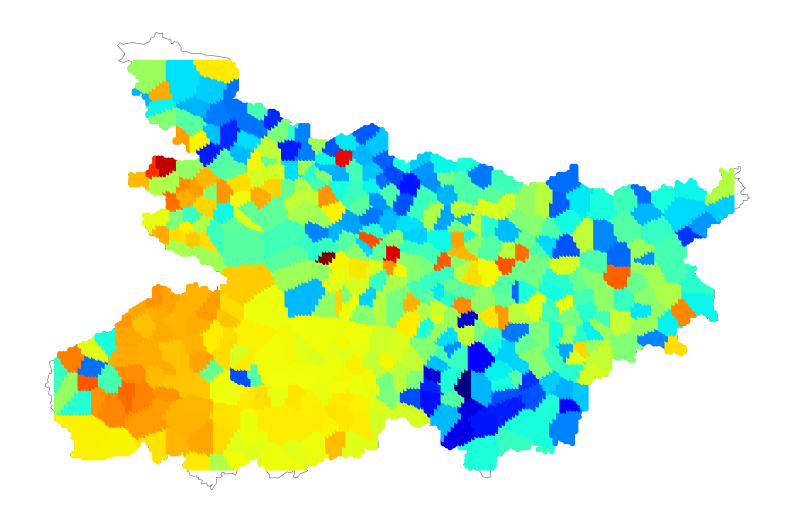

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))

norm = Normalize(vmin=min(values), vmax=max(values))
my_cmap = cm.get_cmap('jet')
my_cmap.set_over('darkred')
my_cmap.set_under('blue')

bihar.plot(ax=ax, color='white', edgecolor='grey', linewidth=0.5)
scatter = ax.scatter(data_long, data_lat, c=values, cmap=my_cmap, marker='.')

ax.set_axis_off()
plt.show()